## Outside of the Container:

In [3]:
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
import os
import shutil

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [4]:
def cropped_pc_from_bounds(pts: np.array, min_bounds: np.array, max_bounds: np.array):
    """
    Bounds a point cloud to a specified world boundary.

    Args:
      pts: A numpy array of shape (N, 3) representing the point cloud.
      min_bounds: A numpy array of shape (1, 3) representing the world bounds [x, y, z]
      max_bounds: A numpy array of shape (1, 3) representing the world bounds [x, y, z]

    Returns:
      A numpy array of shape (M, 3) representing the bounded point cloud,
      or None if no points remain within the bounds.
    """

    # Apply boolean mask to filter points within bounds
    valid = (
        (pts[:, 0] >= min_bounds[0])
        & (pts[:, 0] <= max_bounds[0])
        & (pts[:, 1] >= min_bounds[1])
        & (pts[:, 1] <= max_bounds[1])
        & (pts[:, 2] >= min_bounds[2])
        & (pts[:, 2] <= max_bounds[2])
    )
    pts_filtered = pts[valid]

    # Check if any points remain
    if not np.any(valid):
        print("no valid points")
        return None

    return pts_filtered

def crop_ply(file_key, bbox_dict, do_crop=True):
  if file_key not in bbox_dict:
    print('wrong file name')
    return
  file_path = bbox_dict[file_key]['path']
  pcd = o3d.io.read_point_cloud(file_path)

  if do_crop:
    centroid = bbox_dict[file_key]['centroid']
    dims = bbox_dict[file_key]['dims']
    # Crop the point cloud
    min_bounds = [c - size/2 for (c, size) in zip(centroid, dims)]
    max_bounds = [c + size/2 for (c, size) in zip(centroid, dims)]

  else:
    centroid = pcd.get_center()
    min_bounds = pcd.get_min_bound()
    max_bounds = pcd.get_max_bound()


  filename = os.path.basename(file_path)
  name, _ = os.path.splitext(filename)

  directory = os.path.dirname(file_path)

  cropped_pc_path = os.path.join(directory, f'{name}_cropped.ply')
  cropped_pc_np_path = os.path.join(directory, f'{name}_cropped.npy')

  bbox_dict[file_key]['name'] = name
  bbox_dict[file_key]['np_path'] = cropped_pc_np_path
  bbox_dict[file_key]['cropped_path'] = cropped_pc_path


  xyz_min = np.minimum(min_bounds, max_bounds)
  xyz_max = np.maximum(min_bounds, max_bounds)


  cropped_point_cloud = pcd.crop(
    o3d.geometry.AxisAlignedBoundingBox(min_bound=xyz_min, max_bound=xyz_max)
  )

  # Save the cropped pc with color:
  o3d.io.write_point_cloud(cropped_pc_path, cropped_point_cloud)

  # Save just the points as a np file for
  print(np.asarray(cropped_point_cloud.points).shape)
  np.save(cropped_pc_np_path, np.asarray(cropped_point_cloud.points))

  print("Saved both np and ply files!")
  return bbox_dict

def pc_from_np_array(pc_confs):
    # Create PointCloud object
  point_cloud = o3d.geometry.PointCloud()
  points = np.zeros((len(pc_confs), 3))
  points[:, 0] = pc_confs['x']
  points[:, 1] = pc_confs['y']
  points[:, 2] = pc_confs['z']
  point_cloud.points = o3d.utility.Vector3dVector(points)


  colors = np.zeros((len(pc_confs), 3))
  colors[:, 0] = pc_confs['r']
  colors[:, 1] = pc_confs['g']
  colors[:, 2] = pc_confs['b']
  point_cloud.colors = o3d.utility.Vector3dVector(colors)

  return point_cloud

In [5]:
# bbox_dict = {"B_rtab":
#             {"path": "/home/mmicatka/Documents/raven_manipulation/src/grasp_synthesis/src/grasp_synthesis/tsgrasp/test_pointclouds/B_90s_rtabmap.ply",
#              "centroid": [-0.00470451, 0.02, 0.43373715],
#             "dims": [0.15, 0.13, 0.15]},
#             "B_stereo":
#             {"path": "/home/mmicatka/Documents/raven_manipulation/src/grasp_synthesis/src/grasp_synthesis/tsgrasp/test_pointclouds/B_90s_stereo.ply",
#              "centroid": [0.767615, -0.15350854, 0.33755865],
#             "dims": [0.15, 0.16, 0.15]}}
bbox_dict = {"C_rtab":
            {"path": "/home/mmicatka/Documents/point_clouds/files/pointclouds/C_190s_rtabmap.ply"},
            "C_stereo":
            {"path": "/home/mmicatka/Documents/point_clouds/files/pointclouds/C_190s_stereo.ply"},
            "D_rtab":
            {"path": "/home/mmicatka/Documents/point_clouds/files/pointclouds/D_150s_rtabmap.ply"},
            "D_stereo":
            {"path": "/home/mmicatka/Documents/point_clouds/files/pointclouds/D_150s_stereo.ply"}}
bbox_dict = crop_ply("C_rtab", bbox_dict, do_crop=False)
bbox_dict = crop_ply("C_stereo", bbox_dict, do_crop=False)
bbox_dict = crop_ply("D_rtab", bbox_dict, do_crop=False)
bbox_dict = crop_ply("D_stereo", bbox_dict, do_crop=False)

# copy files into tsgrasp dir
pc_dir = "/home/mmicatka/Documents/raven_manipulation/src/grasp_synthesis/src/grasp_synthesis/tsgrasp/test_pointclouds"

for k, v in bbox_dict.items():
    try:
        shutil.copy(v["np_path"], pc_dir)
        name = v["name"]

         # these doesn't exist yet, but create the entry:
        v['pc_confs_path_np'] = os.path.join(pc_dir, f'{name}_cropped_confs.npy')
        v['grasps_path'] = os.path.join(pc_dir, f'{name}_cropped_grasps.npy')
        v['pc_confs_path'] = os.path.join(pc_dir, f'{name}_cropped_confs.ply')

    except Exception as ex:
        print(ex)

(5526, 3)
Saved both np and ply files!
(50168, 3)
Saved both np and ply files!
(1930, 3)
Saved both np and ply files!
(11381, 3)
Saved both np and ply files!


In [6]:
input_path = "/home/mmicatka/Documents/point_clouds/files/pointclouds/B_90s.ply"
output_path = "/home/mmicatka/Documents/point_clouds/files/pointclouds/B_90s_clipped.ply"
pcd = o3d.io.read_point_cloud(input_path)

print(f"center: {pcd.get_center()}")
print(f"max: {pcd.get_max_bound()}")
print(f"min: {pcd.get_min_bound()}")
print()

cropped_pc = pcd.crop(
o3d.geometry.AxisAlignedBoundingBox(min_bound=[0, -1, -1], max_bound=[1, 1, 1]))
print(f"center: {cropped_pc.get_center()}")
print(f"max: {cropped_pc.get_max_bound()}")
print(f"min: {cropped_pc.get_min_bound()}")

# # Save the cropped pc with color:
o3d.io.write_point_cloud(output_path, cropped_pc)


center: [ 2.13456533 -0.10127896  0.60338978]
max: [5.45461559 3.4542129  4.17021513]
min: [ 0.26422286 -3.65184212 -0.20542109]

center: [0.83515375 0.14089649 0.68181324]
max: [0.99999678 0.95386666 0.99999934]
min: [ 0.26422286 -0.99796349 -0.20542109]


True

In [6]:
for k, v in bbox_dict.items():
    print(k)
    for ki, vi in v.items():

        print("  ", ki, vi)

C_rtab
   path /home/mmicatka/Documents/point_clouds/files/pointclouds/C_190s_rtabmap.ply
   name C_190s_rtabmap
   np_path /home/mmicatka/Documents/point_clouds/files/pointclouds/C_190s_rtabmap_cropped.npy
   cropped_path /home/mmicatka/Documents/point_clouds/files/pointclouds/C_190s_rtabmap_cropped.ply
   pc_confs_path_np /home/mmicatka/Documents/raven_manipulation/src/grasp_synthesis/src/grasp_synthesis/tsgrasp/test_pointclouds/C_190s_rtabmap_cropped_confs.npy
   grasps_path /home/mmicatka/Documents/raven_manipulation/src/grasp_synthesis/src/grasp_synthesis/tsgrasp/test_pointclouds/C_190s_rtabmap_cropped_grasps.npy
   pc_confs_path /home/mmicatka/Documents/raven_manipulation/src/grasp_synthesis/src/grasp_synthesis/tsgrasp/test_pointclouds/C_190s_rtabmap_cropped_confs.ply
C_stereo
   path /home/mmicatka/Documents/point_clouds/files/pointclouds/C_190s_stereo.ply
   name C_190s_stereo
   np_path /home/mmicatka/Documents/point_clouds/files/pointclouds/C_190s_stereo_cropped.npy
   croppe

## In Container

In [98]:
'''
(in /nodes)
`./run.sh`

Inside container:
cd grasp_synth_ws/src/grasp_synthesis/src/grasp_synthesis/tsgrasp/
jupyter notebook --ip 0.0.0.0  --allow-root
'''

'\n(in /nodes)\n`./run.sh`\n\nInside container:\ncd grasp_synth_ws/src/grasp_synthesis/src/grasp_synthesis/tsgrasp/\njupyter notebook --ip 0.0.0.0  --allow-root\n'

In [1]:
# Standard Library
import numpy as np
import torch
assert torch.cuda.is_available(), "cant access cuda. yikes"
from predict_grasps import GraspPredictor
import yaml
import os

def model_metadata_from_yaml(yaml_file_path: str) -> dict:
    metadata = {}
    try:
        with open(yaml_file_path, "r", encoding="utf-8") as stream:
            metadata = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)
    return metadata

# Create the predictor:
pkg_root = "/grasp_synth/grasp_synth_ws/src/grasp_synthesis/"
model_metadata = model_metadata_from_yaml(os.path.join(os.getcwd(), "models/tsgrasp_scene_1_frame/metadata.yaml"))
model_path = os.path.join(pkg_root, model_metadata["ckpt_path"])
grasp_predictor = GraspPredictor(model_metadata, False, pkg_root)
print('done')

In [8]:
# Load the points:
pc_dir = os.path.join(os.getcwd(), "test_pointclouds")
files = os.listdir(pc_dir)
npy_files = [file for file in files if file.endswith('.npy')]

grasp_dict = {}
for file in npy_files:
    key = os.path.splitext(file)[0]

    # Load the points
    full_file_name = os.path.join(pc_dir, file)
    cropped_points = np.load(full_file_name)

    # Run the detector:
    grasps, pc_confs = grasp_predictor.detect(cropped_points)
    print(f'working on {full_file_name}')
    print(cropped_points.shape)
    print(len(grasps), pc_confs.shape)

    # save the points
    filename = os.path.join(pc_dir, f"{key}_confs.npy")
    np.save(filename, pc_confs)

    # Save the conf array:
    filename = os.path.join(pc_dir, f"{key}_grasps.npy")
    confs = np.array([grasp.conf for grasp in grasps])
    np.save(filename, confs)

working on /grasp_synth/grasp_synth_ws/src/grasp_synthesis/src/grasp_synthesis/tsgrasp/test_pointclouds/a_pc_cropped.npy
(43642, 3)
500 (5456,)
working on /grasp_synth/grasp_synth_ws/src/grasp_synthesis/src/grasp_synthesis/tsgrasp/test_pointclouds/a_rtab_pc_cropped.npy
(0, 3)


TypeError: object of type 'NoneType' has no len()

## Outside the Container


C_rtab
(2763, 3)


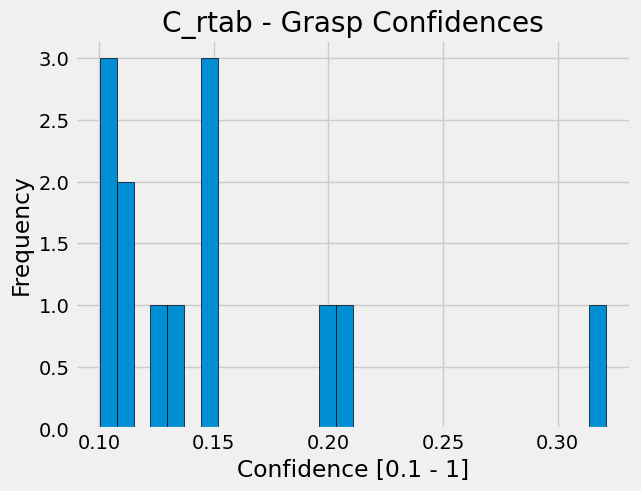

C_stereo
(25084, 3)


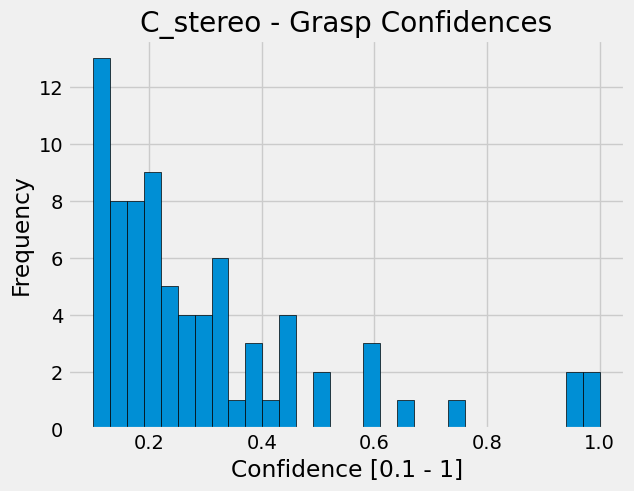

D_rtab
(965, 3)


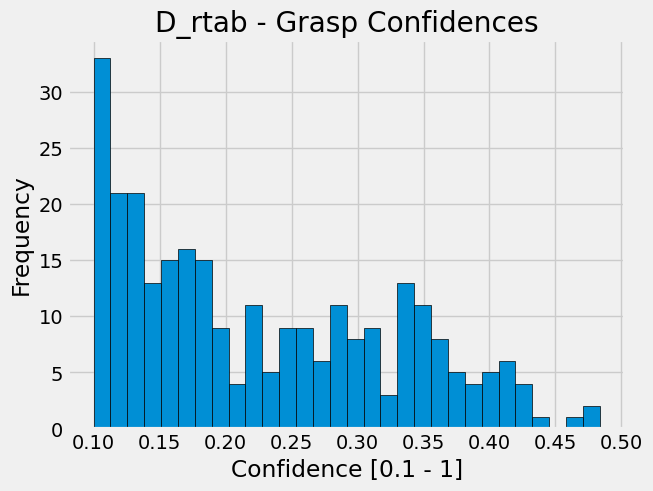

D_stereo
(5690, 3)


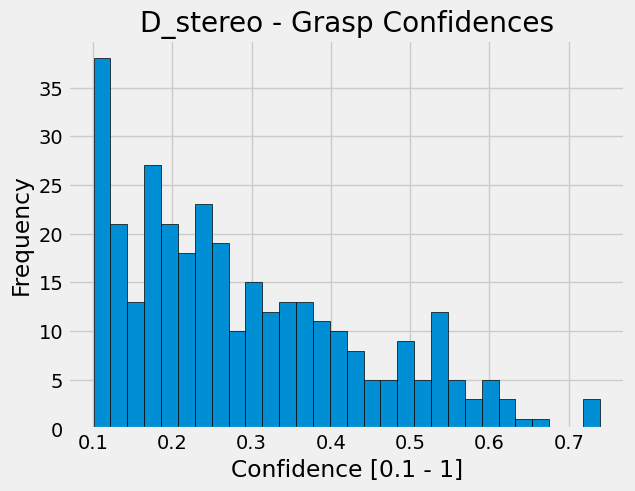

In [7]:
grasps = []
for k, v in bbox_dict.items():
    print(k)
    # load the pc_conf
    pc_confs_path  = v["pc_confs_path_np"]
    pc_confs = np.load(pc_confs_path)
    pcd = pc_from_np_array(pc_confs)

    # Write the pointcloud as a ply:
    print(np.asarray(pcd.points).shape)
    o3d.io.write_point_cloud(v["pc_confs_path"], pcd)

    # load grasps
    grasps_path = v["grasps_path"]
    grasp_array = np.load(grasps_path)
    grasp_array = grasp_array[grasp_array >= 0.1]

    plt.style.use('fivethirtyeight')
    plt.hist(grasp_array, bins=30, edgecolor='black')

    # Add labels and title
    plt.xlabel('Confidence [0.1 - 1]')
    plt.ylabel('Frequency')
    plt.title(f'{k} - Grasp Confidences')

    # Show plot
    plt.show()
